In [2]:
!pip install gym==0.19.0

     |████████████████████████████████| 1.6 MB 5.7 MB/s 
  Created wheel for gym: filename=gym-0.19.0-py3-none-any.whl size=1663116 sha256=c4eb98bddf8ac17421311e83c7e7fd53a2cf5c8b4faee89c225066756b89f670
  Stored in directory: /root/.cache/pip/wheels/ef/9d/70/8bea53f7edec2fdb4f98d9d64ac9f11aea95dfcb98099d7712
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [3]:
import random

import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

env = gym.make('Copy-v0')
actions = [(0, 0, 0),
           (0, 0, 1),
           (0, 0, 2),
           (0, 0, 3),
           (0, 0, 4),
           (0, 1, 0),
           (0, 1, 1),
           (0, 1, 2),
           (0, 1, 3),
           (0, 1, 4),
           (1, 0, 0),
           (1, 0, 1),
           (1, 0, 2),
           (1, 0, 3),
           (1, 0, 4),
           (1, 1, 0),
           (1, 1, 1),
           (1, 1, 2),
           (1, 1, 3),
           (1, 1, 4)]

In [156]:
# constants
EPSILON = 0.15
ALPHA = 0.0002
GAMMA = 0.9

In [140]:
print('State:', env.observation_space)
print('Action:', env.action_space)
print('Num actions:', len(actions))

State: Discrete(6)
Action: Tuple(Discrete(2), Discrete(2), Discrete(5))
Num actions: 20


In [135]:
enc_state = OneHotEncoder()
X = np.array([0,1,2,3,4,5]).reshape(-1,1)
enc_state.fit(X)

enc_action_pred = OneHotEncoder()
Y = np.array([0,1,2,3,4]).reshape(-1,1)
enc_action_pred.fit(Y)

OneHotEncoder()

In [136]:
# initial state
# for each action:
#   compute features from (state, action)
#   forward pass features
#   output is single q value
# taken: max(q_vals) or random action


def make_input(state, action):
    state_enc = enc_state.transform(np.array([state]).reshape(-1, 1)).toarray()[0]
    pred_enc = enc_action_pred.transform(np.array([action[2]]).reshape(-1, 1)).toarray()[0]
    return tf.constant([np.concatenate((state_enc, [action[0], action[1]], pred_enc))])

In [191]:
# test input is made correctly
make_input(3, (0, 1, 3))

<tf.Tensor: shape=(1, 13), dtype=float64, numpy=array([[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]])>

In [157]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(13,)),
    tf.keras.layers.Dense(15, activation='relu', kernel_initializer=initializers.he_normal()),
    tf.keras.layers.Dense(15, activation='relu', kernel_initializer=initializers.he_normal()),
    # tf.keras.layers.Dense(25, activation='relu', kernel_initializer=initializers.he_normal()),
    tf.keras.layers.Dense(1, activation='linear', kernel_initializer=initializers.he_normal())
])

In [158]:
all_episode_rewards = []
all_td_errors = []
td_errors_neg_1 = []
td_errors_neg_half = []
moving_avg = []

# plot how q vals change over time for each state,action in dictionary
all_q = {}
best_100_avg = float('-inf')
for i in range(4000):
    observation = env.reset()
    episode_reward = 0
    episode_td_error = 0
    
    # if len(all_q) > 119:
    #   print('Converged', len(all_q))

    for j in range(100):
        with tf.GradientTape() as tape:
            rand = random.random()
            # env.render()
            if rand < EPSILON:
                print(rand)
                action = env.action_space.sample()
            else:
                q_vals = []
                # get max q value of actions from the current state
                for poss_action in actions:
                    est_val = tf.squeeze(model(make_input(observation, poss_action)))
                    try:
                      all_q[tuple([observation, poss_action[0], poss_action[1], 
                                   poss_action[2]])].append(est_val)
                    except KeyError:
                      all_q[tuple([observation, poss_action[0], poss_action[1], 
                                   poss_action[2]])] = []
                    # print('action', poss_action)
                    # print('value', est_val)
                    q_vals.append(est_val)

                best_idx = np.argmax(q_vals)
                action = actions[best_idx]

            next_state, reward, done, info = env.step(action)

            # obtain next best q value
            if done:
                max_next_q = tf.convert_to_tensor(0, dtype=tf.float32)
            else:
                next_q_vals = []
                for next_action in actions:
                    next_q_vals.append(tf.stop_gradient(tf.squeeze(model(make_input(next_state, next_action)))))
                max_next_q = max(next_q_vals)

            # perform updates
            curr_q = tf.squeeze(model(make_input(observation, action)))
            target = reward + (GAMMA * max_next_q)
            td_err = (target - curr_q) ** 2

            # apply gradients
            grads = tape.gradient(td_err, model.trainable_variables)
            opt = tf.keras.optimizers.Adam(learning_rate=ALPHA)
            opt.apply_gradients(zip(grads, model.trainable_variables))

            episode_td_error += td_err
            episode_reward += reward
            if done:
              break
            observation = next_state

    all_episode_rewards.append(episode_reward)
    last_100_avg = np.mean(all_episode_rewards[-100:])
    moving_avg.append(last_100_avg)
    print(f'Episode {i} finished after {j} timesteps, ep reward: {episode_reward}, last 100 ep reward: {last_100_avg}, td err: {episode_td_error}')
    if last_100_avg > best_100_avg:
      best_100_avg = last_100_avg
      print('...saving weights...')
      model.save_weights('bestWeights.h5')

    all_td_errors.append(episode_td_error) 
    if episode_reward == -0.5:
      td_errors_neg_half.append(episode_td_error)
    elif episode_reward == -1.0:
      td_errors_neg_1.append(episode_td_error)

Episode 0 finished after 0 timesteps, ep reward: -0.5, last 100 ep reward: -0.5, td err: 9.437661170959473
...saving weights...
Episode 1 finished after 0 timesteps, ep reward: -0.5, last 100 ep reward: -0.5, td err: 6.123323917388916
Episode 2 finished after 1 timesteps, ep reward: 0.5, last 100 ep reward: -0.16666666666666666, td err: 12.512994766235352
...saving weights...
Episode 3 finished after 0 timesteps, ep reward: -0.5, last 100 ep reward: -0.25, td err: 12.393221855163574
0.022586302074512954
Episode 4 finished after 1 timesteps, ep reward: -0.5, last 100 ep reward: -0.3, td err: 23.362194061279297
Episode 5 finished after 0 timesteps, ep reward: -0.5, last 100 ep reward: -0.3333333333333333, td err: 12.263490676879883
Episode 6 finished after 0 timesteps, ep reward: -0.5, last 100 ep reward: -0.35714285714285715, td err: 12.189221382141113
Episode 7 finished after 0 timesteps, ep reward: -0.5, last 100 ep reward: -0.375, td err: 11.527717590332031
Episode 8 finished after 0

KeyboardInterrupt: ignored

In [114]:
# for running from checkpoint
for i in range(1500):
    observation = env.reset()
    episode_reward = 0
    episode_td_error = 0
    
    # if len(all_q) > 119:
    #   print('Converged', len(all_q))

    for j in range(100):
        with tf.GradientTape() as tape:
            rand = random.random()
            # env.render()
            if rand < EPSILON:
                print(rand)
                action = env.action_space.sample()
            else:
                q_vals = []
                # get max q value of actions from the current state
                for poss_action in actions:
                    est_val = tf.squeeze(model(make_input(observation, poss_action)))
                    try:
                      all_q[tuple([observation, poss_action[0], poss_action[1], 
                                   poss_action[2]])].append(est_val)
                    except KeyError:
                      all_q[tuple([observation, poss_action[0], poss_action[1], 
                                   poss_action[2]])] = []
                    # print('action', poss_action)
                    # print('value', est_val)
                    q_vals.append(est_val)

                best_idx = np.argmax(q_vals)
                action = actions[best_idx]
                # print(q_vals)
                # print(actions)
                # print(action)

            next_state, reward, done, info = env.step(action)

            # obtain next best q value
            if done:
                max_next_q = tf.convert_to_tensor(0, dtype=tf.float32)
            else:
                next_q_vals = []
                for next_action in actions:
                    next_q_vals.append(tf.stop_gradient(tf.squeeze(model(make_input(next_state, next_action)))))
                max_next_q = max(next_q_vals)

            # perform updates
            curr_q = tf.squeeze(model(make_input(observation, action)))
            target = reward + (GAMMA * max_next_q)
            td_err = (target - curr_q) ** 2

            # apply gradients
            grads = tape.gradient(td_err, model.trainable_variables)
            opt = tf.keras.optimizers.Adam(learning_rate=ALPHA)
            opt.apply_gradients(zip(grads, model.trainable_variables))

            episode_td_error += td_err
            episode_reward += reward
            if done:
              break
            observation = next_state

    all_episode_rewards.append(episode_reward)
    last_100_avg = np.mean(all_episode_rewards[-100:])
    moving_avg.append(last_100_avg)
    print(f'Episode {i} finished after {j} timesteps, ep reward: {episode_reward}, last 100 ep reward: {last_100_avg}, td err: {episode_td_error}')
    if last_100_avg > best_100_avg:
      best_100_avg = last_100_avg
      print('...saving weights...')
      model.save_weights('bestWeights.h5')

    all_td_errors.append(episode_td_error) 
    if episode_reward == -0.5:
      td_errors_neg_half.append(episode_td_error)
    elif episode_reward == -1.0:
      td_errors_neg_1.append(episode_td_error)

Episode 0 finished after 8 timesteps, ep reward: -1.0, last 100 ep reward: -0.655, td err: 1.0048284530639648
0.04642725743765408
Episode 1 finished after 6 timesteps, ep reward: -0.5, last 100 ep reward: -0.655, td err: 0.06987134367227554


KeyboardInterrupt: ignored

[<tf.Tensor: shape=(), dtype=float32, numpy=2.7129416>, <tf.Tensor: shape=(), dtype=float32, numpy=2.7020326>, <tf.Tensor: shape=(), dtype=float32, numpy=2.6956291>, <tf.Tensor: shape=(), dtype=float32, numpy=2.6833825>, <tf.Tensor: shape=(), dtype=float32, numpy=2.6670961>, <tf.Tensor: shape=(), dtype=float32, numpy=2.6496243>, <tf.Tensor: shape=(), dtype=float32, numpy=2.6416428>, <tf.Tensor: shape=(), dtype=float32, numpy=2.6075332>, <tf.Tensor: shape=(), dtype=float32, numpy=2.5466597>, <tf.Tensor: shape=(), dtype=float32, numpy=2.5295417>, <tf.Tensor: shape=(), dtype=float32, numpy=2.4916816>, <tf.Tensor: shape=(), dtype=float32, numpy=2.4849286>, <tf.Tensor: shape=(), dtype=float32, numpy=2.470941>, <tf.Tensor: shape=(), dtype=float32, numpy=2.4483762>, <tf.Tensor: shape=(), dtype=float32, numpy=2.4294868>, <tf.Tensor: shape=(), dtype=float32, numpy=2.4230125>, <tf.Tensor: shape=(), dtype=float32, numpy=2.395016>, <tf.Tensor: shape=(), dtype=float32, numpy=2.3789475>, <tf.Tensor:

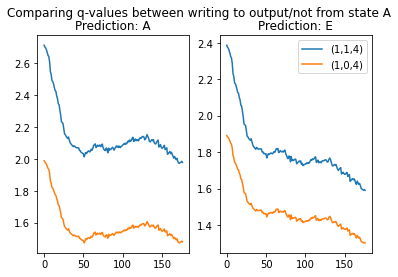

In [159]:
fig, (ax1, ax2) = plt.subplots(1, 2)
print(all_q[tuple([0, 1, 1, 0])])
ax1.plot(all_q[tuple([0, 1, 1, 0])], label='(1,1,0)')
ax1.plot(all_q[tuple([0, 1, 0, 0])], label='(1,0,0)')
ax1.set_title('Prediction: A')
# ax1.set_ylim([-2, ymax])
ax2.plot(all_q[tuple([0, 1, 1, 4])], label='(1,1,4)')
ax2.plot(all_q[tuple([0, 1, 0, 4])], label='(1,0,4)')
ax2.set_title('Prediction: E')
# ax2.set_ylim([ymin, ymax])
fig.suptitle('Comparing q-values between writing to output/not from state A')
plt.legend()

plt.show()

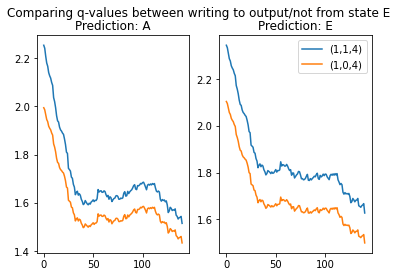

In [160]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(all_q[tuple([4, 1, 1, 0])], label='(1,1,0)')
ax1.plot(all_q[tuple([4, 1, 0, 0])], label='(1,0,0)')
ax1.set_title('Prediction: A')
# ax1.set_ylim([-2, ymax])
ax2.plot(all_q[tuple([4, 1, 1, 4])], label='(1,1,4)')
ax2.plot(all_q[tuple([4, 1, 0, 4])], label='(1,0,4)')
ax2.set_title('Prediction: E')
# ax2.set_ylim([ymin, ymax])
fig.suptitle('Comparing q-values between writing to output/not from state E')
plt.legend()

Text(0.5, 1.0, 'TD-error over time')

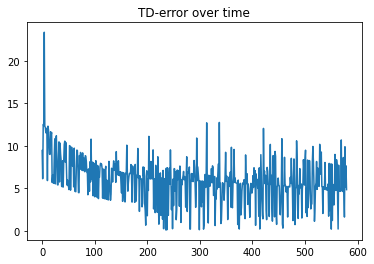

In [161]:
plt.plot(all_td_errors)
plt.title('TD-error over time')

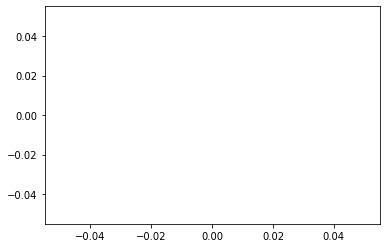

In [162]:
plt.plot(td_errors_neg_1)

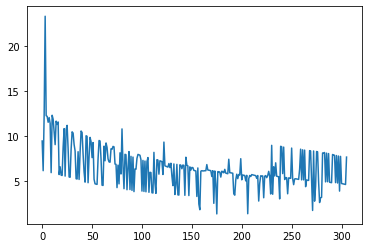

In [163]:
plt.plot(td_errors_neg_half)

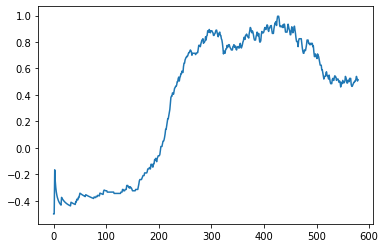

In [164]:
plt.plot(moving_avg)

In [90]:
print('...saving weights...')
model.save_weights('interestingCheckpoint.h5')

...saving weights...


In [165]:
# Obtain the current policy and q-values
# Optimal is (1,1,0),(1,1,1),(1,1,2),(1,1,3),(1,1,4),(1,1,5)

policy = []
all_qs = []
bestAction = None
for state in range(6):
    bestQVal = float('-inf')
    for action in actions:
        # getting qVal by making forward pass through trained network
        qVal = model(make_input(state, action))
        all_qs.append(qVal.numpy()[0][0])
        # print(qVal.numpy())
        if qVal > bestQVal:
            bestAction = action
            bestQVal = qVal
    # print('Best q:', bestQVal)
    policy.append(bestAction)

print(policy)
print(all_qs)


[(1, 1, 0), (1, 1, 4), (1, 1, 0), (0, 1, 3), (1, 1, 4), (0, 1, 0)]
[0.97291875, 0.67045486, 1.1949096, 0.69041824, 0.88149524, 1.1967123, 1.131052, 1.3884037, 1.0557338, 1.0647984, 1.4811904, 1.051229, 1.465938, 0.9674405, 1.3043423, 1.9789546, 1.4530597, 1.8726978, 1.1669194, 1.59446, 0.942047, 0.73427844, 1.0767428, 0.75962746, 0.7973733, 1.1522379, 1.5020283, 1.1931164, 0.9979061, 1.0852314, 1.3917817, 1.1131889, 1.4660115, 0.9114368, 1.3222194, 1.6224949, 1.5572779, 1.5991266, 1.0807462, 1.6382073, 1.3274566, 1.0390972, 1.4486234, 0.94478714, 1.118877, 1.6584568, 1.7478855, 1.8145809, 1.1607429, 1.3306265, 1.9107593, 1.4611403, 1.9091539, 1.1945009, 1.6031241, 2.255381, 1.9085387, 2.2369761, 1.3236765, 1.9012564, 0.607797, 0.84257305, 0.6700916, 0.70398617, 0.42301592, 1.1112423, 1.2923802, 1.087559, 1.3838542, 0.85175073, 0.31733465, 0.57764864, 0.40948603, 0.3806449, 0.48035464, 0.59363174, 0.7895658, 0.6472131, 0.5008937, 0.844785, 1.1918037, 0.7243072, 1.1054785, 1.0668285, 0.8

In [166]:
# Obtain the best policy and q-values approximated during training
# Optimal is (1,1,0),(1,1,1),(1,1,2),(1,1,3),(1,1,4),(x,0,x)

mod = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(13,)),
        tf.keras.layers.Dense(15, activation='relu', kernel_initializer=initializers.he_normal()),
        tf.keras.layers.Dense(15, activation='relu', kernel_initializer=initializers.he_normal()),
        # tf.keras.layers.Dense(25, activation='relu', kernel_initializer=initializers.he_normal()),
        tf.keras.layers.Dense(1, activation='linear', kernel_initializer=initializers.he_normal())
      ])
mod.load_weights('bestWeights.h5')

policy = []
all_qs = []
bestAction = None
for state in range(6):
    bestQVal = float('-inf')
    for action in actions:
        # getting qVal by making forward pass through trained network
        qVal = mod(make_input(state, action))
        all_qs.append(qVal.numpy()[0][0])
        # print(qVal.numpy())
        if qVal > bestQVal:
            bestAction = action
            bestQVal = qVal
    # print('Best q:', bestQVal)
    policy.append(bestAction)

print(policy)
print(all_qs)

[(1, 1, 0), (1, 1, 4), (1, 1, 2), (0, 1, 3), (1, 1, 4), (0, 1, 2)]
[1.0517992, 0.70395756, 1.309815, 0.6950474, 0.9621276, 1.3006699, 1.203459, 1.510126, 1.0831033, 1.1793299, 1.5966204, 1.1155539, 1.6060301, 1.0134668, 1.4410015, 2.1399128, 1.5381104, 2.0532126, 1.2295787, 1.7601386, 1.0623325, 0.78282213, 1.2091317, 0.76681376, 0.91678977, 1.3209729, 1.6063483, 1.3784658, 1.032767, 1.232988, 1.5450245, 1.20635, 1.651891, 0.9589492, 1.4821783, 1.825065, 1.6977458, 1.8392178, 1.1457342, 1.8499418, 1.4721411, 1.1150224, 1.6160318, 0.97865057, 1.2596958, 1.8454938, 1.894423, 2.010417, 1.2317007, 1.5133241, 2.100759, 1.5695436, 2.1139064, 1.2684364, 1.7875148, 2.4959557, 2.0538735, 2.4981482, 1.4147207, 2.1440094, 0.6510027, 0.82155, 0.7100467, 0.65026414, 0.43257642, 1.189459, 1.276328, 1.15066, 1.3384515, 0.8829807, 0.3690585, 0.58479035, 0.4745414, 0.3830776, 0.54715705, 0.6662194, 0.8218435, 0.74237806, 0.4910622, 0.93777853, 1.2835872, 0.759331, 1.2182297, 1.0818617, 0.8874711, 1.365

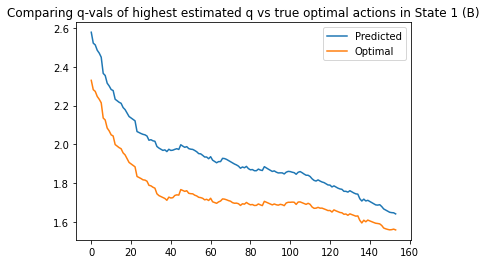

In [186]:
# Visualize why state 1 (B) has an incorrect action

fig = plt.plot(all_q[tuple([1, 1, 1, 4])], label='Predicted')
fig = plt.plot(all_q[tuple([1, 1, 1, 1])], label='Optimal')
plt.title('Comparing q-vals of highest estimated q vs true optimal actions in State 1 (B)')
# ax2.set_ylim([ymin, ymax])
plt.legend()

# We can see that orange's q might have been higher than blue, if we let run for
# more iterations

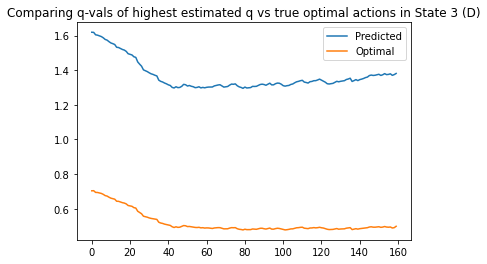

In [188]:
# Visualize why network's state 3 (D) has an incorrect action

fig = plt.plot(all_q[tuple([3, 0, 1, 3])], label='Predicted')
fig = plt.plot(all_q[tuple([3, 1, 1, 3])], label='Optimal')
plt.title('Comparing q-vals of highest estimated q vs true optimal actions in State 3 (D)')
# ax2.set_ylim([ymin, ymax])
plt.legend()

# not too sure

In [190]:
# Use the model to visualize games

import time
for i_episode in range(3):
    observation = env.reset()
    print(observation)
    for t in range(15):
        env.render()
        time.sleep(0.5)
        bestQVal = float('-inf')
        for act in actions:
            # getting qVal by making forward pass through trained network
            qVal = mod(make_input(observation, act))
            # print(qVal.numpy())
            if qVal > bestQVal:
                bestAction = act
                bestQVal = qVal
        action = bestAction
        observation, reward, done, info = env.step(action)
        print(observation)
        env.render()
        print('Reward:', reward)
        if done:
            print(i_episode)
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

4
Total length of input instance: 3, step: 0
Observation Tape    :   EAA  
Output Tape         :   
Targets             :   EAA  






0
Total length of input instance: 3, step: 1
Observation Tape    :   EAA  
Output Tape         :   E
Targets             :   EAA  

Current reward      :   1.000
Cumulative reward   :   1.000
Action              :   Tuple(move over input: right,
                              write to the output tape: True,
                              prediction: E)
Reward: 1.0
Total length of input instance: 3, step: 1
Observation Tape    :   EAA  
Output Tape         :   E
Targets             :   EAA  

Current reward      :   1.000
Cumulative reward   :   1.000
Action              :   Tuple(move over input: right,
                              write to the output tape: True,
                              prediction: E)
0
Total length of input instance: 3, step: 2
Observation Tape    :   EAA  
Output Tape         :   EA
Targets             :   EAA  

Current reward 